In [1]:
import os
os.chdir('../../')
import fff
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import os
import pickle as pkl
matplotlib.rcParams.update({'font.size': 18})

INFO: Using pytorch backend
/tmp/ipykernel_3225617/735068933.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [92]:
model = fff.FreeFormInjectiveFlow.load_from_checkpoint(
    "lightning_logs/all_e42/version_0/checkpoints/last.ckpt"
)

cond_dim:  10
latent_dim:  54
[64, 256, 256, 64]
[64, 256, 256, 64]
[64, 256, 256, 64]
[64, 256, 256, 64]
[64, 256, 256, 64]
[64, 256, 256, 64]
Sequential(
  (0): ConvolutionalNeuralNetwork(
    (model): Sequential(
      (encoder): Sequential(
        (0): Unflatten(dim=-1, unflattened_size=(11, 8, 8))
        (1): Conv2d(11, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): ReLU()
        (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (4): ReLU()
        (5): Conv2d(64, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (6): ReLU()
        (7): Flatten(start_dim=-3, end_dim=-1)
        (8): Linear(in_features=1024, out_features=54, bias=True)
      )
      (decoder): Sequential(
        (0): Linear(in_features=64, out_features=4256, bias=True)
        (1): Unflatten(dim=-1, unflattened_size=(266, 4, 4))
        (2): ConvTranspose2d(266, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
        (

In [93]:
torch.set_grad_enabled(False)

encoding...
torch.Size([5000, 54])
decoding...
decoding...


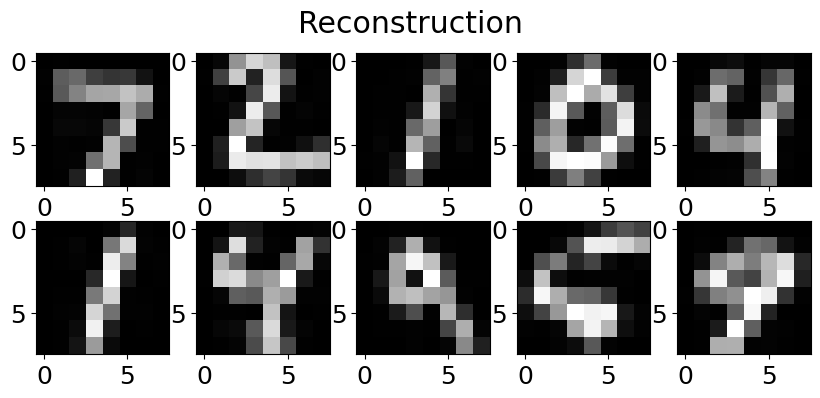

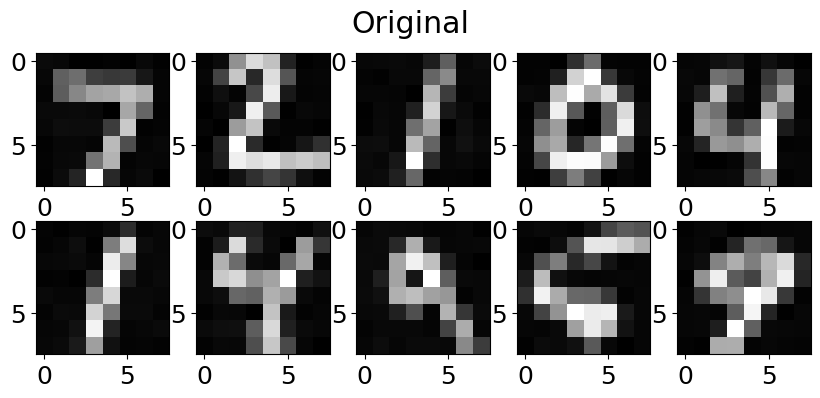

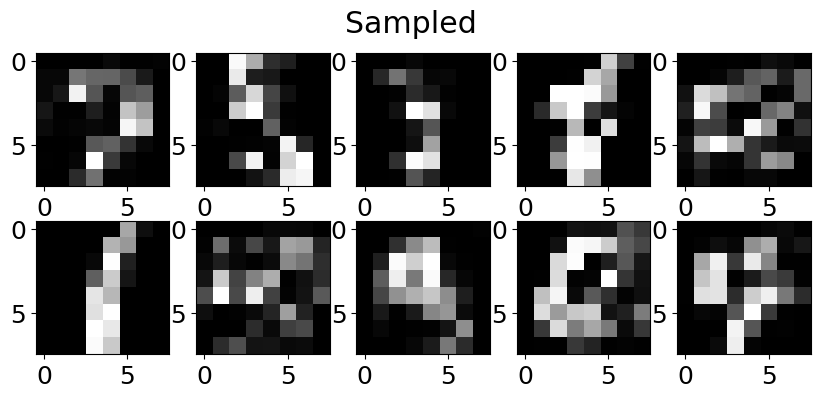

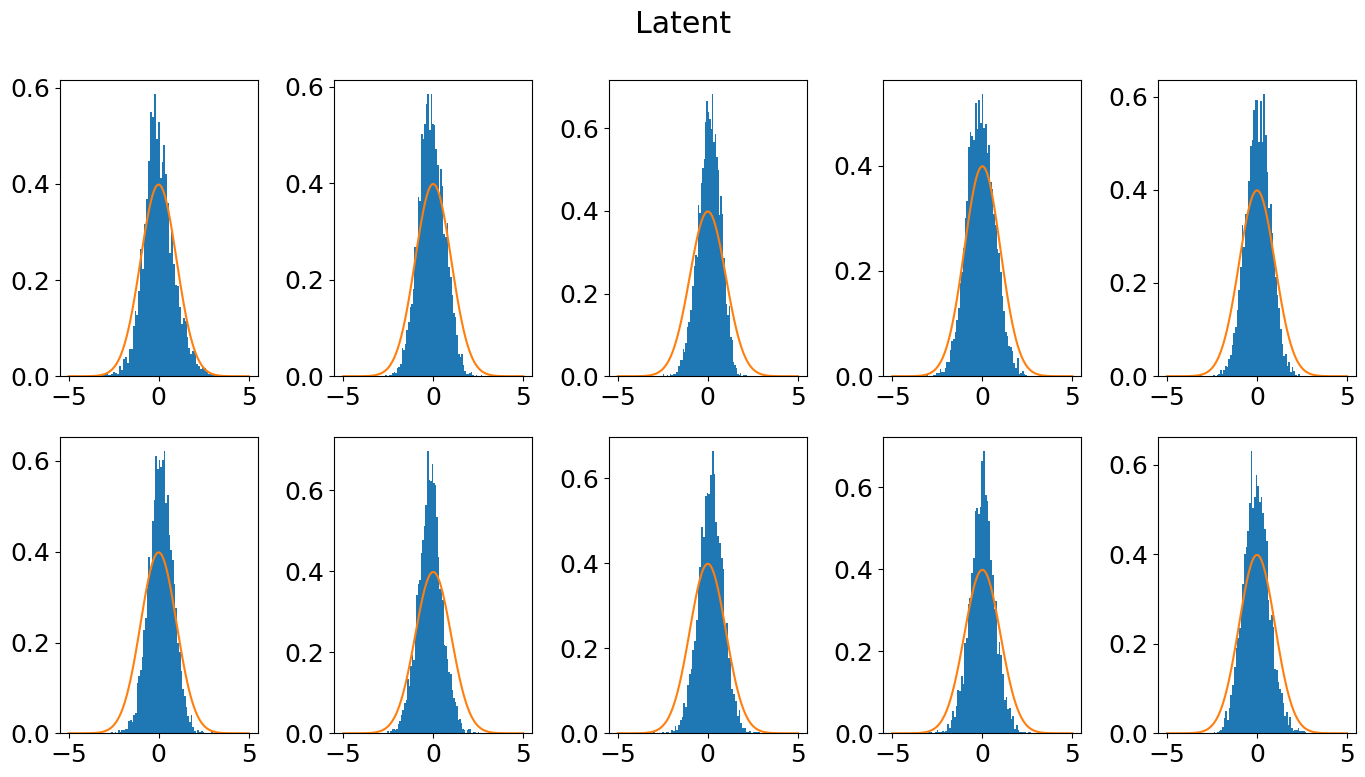

In [94]:
data = plot_mnist(model)

tensor(0.3992)
squared distance between pictures: tensor([0.0637, 0.0658, 0.0667, 0.0667, 0.0676, 0.0686, 0.0722])


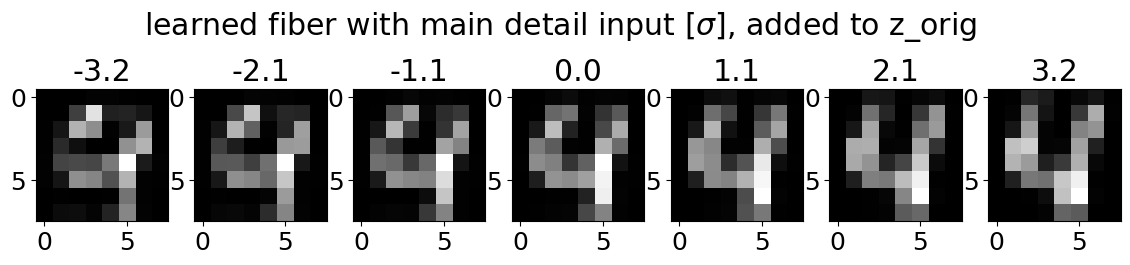

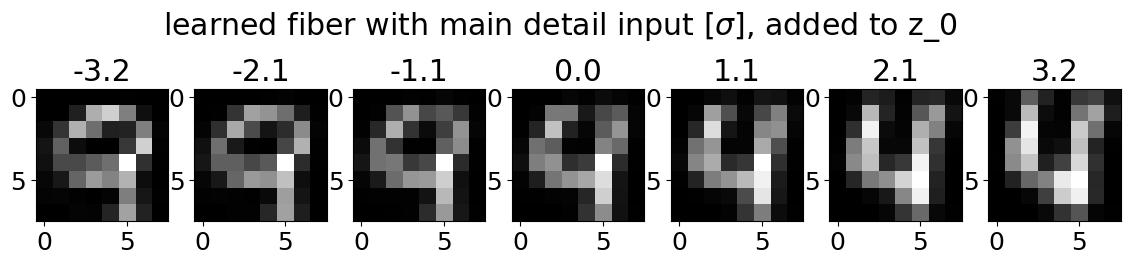

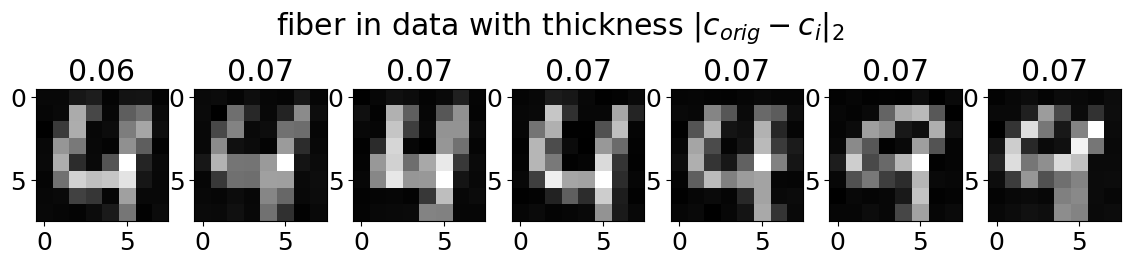

In [96]:
x0, x1, c_orig = plot_details(model, data, 4)

tensor([0.3602, 0.3043, 0.2576, 0.2047, 0.1840, 0.1635, 0.1311, 0.0925, 0.0548,
        0.0440, 0.0793, 0.1098, 0.1438, 0.1857, 0.2325, 0.3033, 0.3817, 0.4548,
        0.5167, 0.5764, 0.6321])


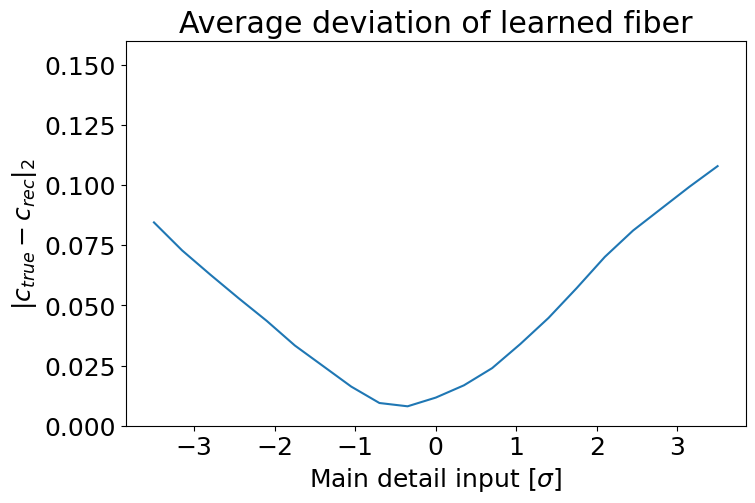

tensor([0.1858, 0.1939, 0.1962, 0.1845, 0.1646, 0.1302, 0.1232, 0.1019, 0.0786,
        0.1130, 0.1250, 0.1235, 0.1124, 0.0966, 0.0900, 0.1206, 0.1910, 0.2632,
        0.3240, 0.3794, 0.4458])


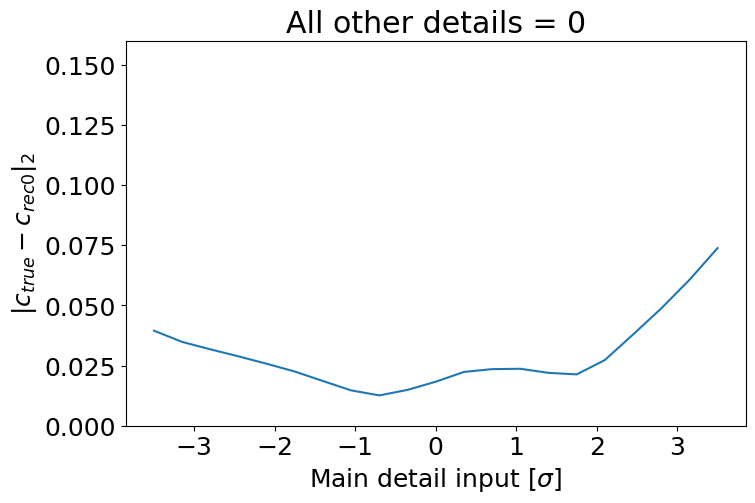

In [82]:
drange = 3.5
conditioned = GT.apply_conditions((x1,))
x = conditioned.x0
c = conditioned.condition
fibre_true = GT.encode(x.to(GT.device), c.to(GT.device)).cpu()
print(torch.max(fibre_true-c_orig, dim=1)[0])
delta_coarse = torch.sqrt(torch.sum((fibre_true-c_orig)**2, dim=1)).numpy()/10

plt.figure(figsize=[8,5])
delta_details = np.linspace(-drange,drange,21)
plt.plot(delta_details,delta_coarse)
plt.title("Average deviation of learned fiber")
plt.xlabel(r"Main detail input [$\sigma$]")
plt.ylabel(r"$|c_{true}-c_{rec}|_2$")
plt.ylim((0,0.16))
plt.savefig("deviation4nm.png")
plt.show()

conditioned = GT.apply_conditions((x0,))
x = conditioned.x0
c = conditioned.condition
fibre_true = GT.encode(x.to(GT.device), c.to(GT.device)).cpu()
print(torch.max(fibre_true-c_orig, dim=1)[0])
delta_coarse = torch.sqrt(torch.sum((fibre_true-c_orig)**2, dim=1)).numpy()/10

plt.figure(figsize=[8,5])
delta_details = np.linspace(-drange,drange,21)
plt.plot(delta_details,delta_coarse)
plt.title("All other details = 0")
plt.xlabel(r"Main detail input [$\sigma$]")
plt.ylabel(r"$|c_{true}-c_{rec0}|_2$")
plt.ylim((0,0.16))
plt.savefig("0deviation4nm.png")
plt.show()

In [83]:
def plot_details(rectangular_flow, data, sample):
    device = rectangular_flow.device
    c = data["val_c"]
    c_train = data["train_c"]
    train_samples = data["train_samples"]
    z = data["val_z"]
    N = 21
    n = 7
    
    pos_min, pos_max = -3.5, 3.5
    detail = torch.linspace(pos_min, pos_max, N)
    detail_l = []
    d0 = z[sample][0]
    print(d0)
    for i in range(N):
        d = z[sample].clone()
        d[0] = detail[i]
        detail_l.append(d)
    details1 = torch.stack(detail_l)
    
    details0 = torch.zeros(N,53)
    details0 = torch.cat([torch.unsqueeze(detail,1), details0], dim=1)
    condition = torch.unsqueeze(c[sample], dim=0)
    condition = condition.repeat(N,1)
    x_details1 = rectangular_flow.decode(details1.to(device), condition.to(device)).cpu()
    x_details0 = rectangular_flow.decode(details0.to(device), condition.to(device)).cpu()


    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(14, 3))
    for i in range(n):
        axes[i].imshow(x_details1[i*N//n+1].cpu().reshape(8, 8), cmap='gray')
        axes[i].set_title(detail[i*N//n+1].numpy().round(1))
    plt.suptitle(r"learned fiber with main detail input [$\sigma$], added to z_orig")
    
    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(14, 3))
    for i in range(n):
        axes[i].imshow(x_details0[i*N//n+1].cpu().reshape(8, 8), cmap='gray')
        axes[i].set_title(detail[i*N//n+1].numpy().round(1))
    plt.suptitle(r"learned fiber with main detail input [$\sigma$], added to z_0")

    verify = c[sample]
    diff = c_train - verify
    squared_diff = torch.sqrt(torch.sum(torch.square(diff), dim =1))
    ind = torch.argsort(squared_diff)[:n]
    print("squared distance between pictures:", squared_diff[ind]/10)
    similar = train_samples[ind]

    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(14, 3))
    for i in range(n):
        axes[i].imshow(similar[i].cpu().reshape(8, 8), cmap='gray')
        axes[i].set_title(np.round(squared_diff[ind[i]].numpy()/10,2))
    fig.suptitle(r"fiber in data with thickness $|c_{orig}-c_i|_2$")
    
    """
    fig = plt.figure(figsize=(13.5, 11))
    fig.suptitle("verifying")
    subfigs = fig.subfigures(nrows=5, ncols=1)
    for row, subfig in enumerate(subfigs):
        subfig.suptitle(detail[row].numpy())
        axes = subfig.subplots(nrows=1, ncols=n+1)
        for j in range(n+1):
            if j==0:
                axes[j].imshow(x_details[row].cpu().reshape(8, 8), cmap='gray')
                axes[j].set_title("learned", fontsize=15)
            else:
                axes[j].imshow(samples[row][j-1].cpu().reshape(8, 8), cmap='gray')
        axes[1].set_title("most similar", fontsize=15)
    """

    return x_details0, x_details1, condition

In [5]:
from fff.evaluate.plots import all_conditions
def plot_mnist(rectangular_flow):
    data = {}
    train_batch = rectangular_flow.train_data[:]
    val_batch = rectangular_flow.test_data[:5000]

    conditioned = rectangular_flow.apply_conditions(train_batch)
    train_samples = conditioned.x0
    c_train = conditioned.condition
    
    conditioned = rectangular_flow.apply_conditions(val_batch)
    #print(val_batch[1][:10])
    c_val = conditioned.condition
    val_samples = conditioned.x0
    
    #print(c.shape)
    #print(val_samples.shape)
    data["train_samples"] = train_samples
    data["val_c"] = c_val
    data["train_c"] = c_train
    
    device = rectangular_flow.device
    
    print("encoding...")
    batch_size = rectangular_flow.hparams.batch_size
    #print(batch_size)
    z_val = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(val_samples.split(batch_size), c_val.split(batch_size))
    ])
    
    data["val_z"] = z_val
    print(z_val.shape)
    print("decoding...")
    x1_val = torch.cat([
        rectangular_flow.decode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(z_val.split(batch_size), c_val.split(batch_size))
    ])
    z_test = torch.randn_like(z_val)
    print("decoding...")
    x1_test = torch.cat([
        rectangular_flow.decode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(z_test.split(batch_size), c_val.split(batch_size))
    ])
    #print(x1_test.shape)

    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
    for i in range(2):
        for j in range(5):
            axes[i][j].imshow(x1_val[i*5 +j].cpu().reshape(8, 8), cmap='gray')
    fig.suptitle("Reconstruction")
    plt.show()
    
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
    for i in range(2):
        for j in range(5):
            axes[i][j].imshow(val_samples[i*5 +j].cpu().reshape(8, 8), cmap='gray')
    fig.suptitle("Original")

    
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
    for i in range(2):
        for j in range(5):
            axes[i][j].imshow(x1_test[i*5 +j].cpu().reshape(8, 8), cmap='gray')
    fig.suptitle("Sampled")

    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(14, 8))
    a = np.linspace(-5,5,100)
    for i in range(2):
        for j in range(5):
            axes[i][j].hist(z_val[:,i*5+j], bins=60, label="Samples", density=True)
            axes[i][j].plot(a, normal(a))
    fig.suptitle("Latent")
    fig.tight_layout()

    return data

In [6]:
def normal(x):
    return np.exp(-x**2/2)/np.sqrt(2*np.pi)

In [7]:
GT = fff.FreeFormInjectiveFlow.load_from_checkpoint(
    "lightning_logs/downsampled/version_5/checkpoints/last.ckpt"
)

torch.Size([60000, 1, 8, 8])
cond_dim:  0
latent_dim:  10
[10, 256, 256, 10]
[10, 256, 256, 10]
[10, 256, 256, 10]
[10, 256, 256, 10]
[10, 256, 256, 10]
[10, 256, 256, 10]
Sequential(
  (0): ConvolutionalNeuralNetwork(
    (model): Sequential(
      (encoder): Sequential(
        (0): Unflatten(dim=-1, unflattened_size=(1, 8, 8))
        (1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): ReLU()
        (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (4): ReLU()
        (5): Conv2d(64, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (6): ReLU()
        (7): Flatten(start_dim=-3, end_dim=-1)
        (8): Linear(in_features=1024, out_features=10, bias=True)
      )
      (decoder): Sequential(
        (0): Linear(in_features=10, out_features=4096, bias=True)
        (1): Unflatten(dim=-1, unflattened_size=(256, 4, 4))
        (2): ConvTranspose2d(256, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output

In [11]:
save_data(model)

encoding traindata...
encoding valdata...
encoding testdata...


In [10]:
def save_data(rectangular_flow):
    train_data = rectangular_flow.train_data[:]
    val_data = rectangular_flow.val_data[:]
    test_data = rectangular_flow.test_data[:]
    
    conditioned = rectangular_flow.apply_conditions(train_data)
    train_samples = conditioned.x_noisy
    c_t = conditioned.condition
    
    conditioned = rectangular_flow.apply_conditions(val_data)
    val_samples = conditioned.x_noisy
    c_v = conditioned.condition

    conditioned = rectangular_flow.apply_conditions(test_data)
    test_samples = conditioned.x_noisy
    c_test = conditioned.condition
    
    device = rectangular_flow.device
    print("encoding traindata...")
    batch_size = rectangular_flow.hparams.batch_size
    z_train = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(train_samples.split(batch_size), c_t.split(batch_size))
    ])
    print("encoding valdata...")
    z_val = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(val_samples.split(batch_size), c_v.split(batch_size))
    ])
    print("encoding testdata...")
    z_test = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(test_samples.split(batch_size), c_test.split(batch_size))
    ])

    data = {}
    
    data["train_x"] = train_samples.cpu().numpy()
    data["train_y"] = z_train.cpu().numpy()
    
    data["val_x"] = val_samples.cpu().numpy()
    data["val_y"] = z_val.cpu().numpy()

    data["test_x"] = test_samples.cpu().numpy()
    data["test_y"] = z_test.cpu().numpy()

    path = "Mnist_AE"
    fileName = path + 'ML_data'
    fileObject = open(fileName, 'wb')
    
    pkl.dump(data, fileObject)
    fileObject.close()